# Project 6: VCFAD - Voice Cloning and Fake Audio Detection
In this project, our goal is to build a machine learning system to detect if a spoken audio file is synthetically generated (or not). Firstly, a voice cloning system will be built that will clone a source speaker’s voice to a target speaker’s voice. A number of ‘fake’ samples will be generated from this system and will be used to train a machine learning system which detects if spoken audio is natural speech or synthetically generated.

### Data Description
There are two datasets we will use for this project:

**TIMIT Dataset**

This dataset contains 6300 sentences (10 sentences spoken by 630 different speakers) and will be used to create a voice cloner that generates fake samples.

**CommonVoice Dataset**

The CommonVoice dataset is large voice dataset containing a corpus of speech data read by users. For our project we will be using Common Voice Delta Segment 12.0 and Common Voice Delta Segment 13.0. Together these datasets contain a total of 110 hours of spoken audio. We will use this data to train our fake speech detection model.

### Project Setup

In [1]:
# Create folders to store our datasets
!mkdir "data"
!mkdir "data/real"
!mkdir "data/fake"
#!mkdir "data/fake_by_speaker"
#!mkdir "data/fake_by_speaker/0"
#!mkdir "data/fake_by_speaker/1"
#!mkdir "data/fake_by_speaker/2"
#!mkdir "data/fake_by_speaker/3"
#!mkdir "data/fake_by_speaker/4"
#!mkdir "data/fake_by_speaker/5"
#!mkdir "data/me_real"
#!mkdir "data/me_fake"

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/real’: File exists
mkdir: cannot create directory ‘data/fake’: File exists
mkdir: cannot create directory ‘data/fake_by_speaker’: File exists
mkdir: cannot create directory ‘data/fake_by_speaker/0’: File exists
mkdir: cannot create directory ‘data/fake_by_speaker/1’: File exists
mkdir: cannot create directory ‘data/fake_by_speaker/2’: File exists
mkdir: cannot create directory ‘data/fake_by_speaker/3’: File exists
mkdir: cannot create directory ‘data/fake_by_speaker/4’: File exists
mkdir: cannot create directory ‘data/fake_by_speaker/5’: File exists


In [2]:
# Install the necessary packages
#!pip install gtts
!pip install pydub
!pip install TTS
!pip3 install numpy==1.21.0
!pip install SpeechRecognition
!pip install --upgrade protobuf
!pip install tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.0
    Uninstalling protobuf-4.23.0:
      Successfully uninstalled protobuf-4.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.0 which is incompatible.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached protobuf-4.23.0-cp37-abi3-manylinux2014_x86_64.whl (304 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboardx 2.6 requires protobuf<4,>=3.8.0, but you have protobuf 4.23.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.0 which is incompatible.
trainer 0.0.20 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.23.0 which is incompatible

In [3]:
# Import the necessary packages
import pandas as pd
from IPython.display import Audio
import subprocess
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randint
from TTS.api import TTS
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
import speech_recognition as sr
from os import path
from pydub import AudioSegment
from imutils import paths

In [8]:
# Mount Google Drive and import datasets
from google.colab import drive
import zipfile
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Datasets/archive.zip", 'r')
zip_ref.extractall("/content/timit")
zip_ref.close()

In [10]:
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Datasets/cv-corpus-12.0-delta-2022-12-07.zip", 'r')
zip_ref.extractall("/content/cv")
zip_ref.close()

In [11]:
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Datasets/cv-corpus-10.0-delta-2022-07-04.zip", 'r')
zip_ref.extractall("/content/cv")
zip_ref.close()

In [12]:
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Datasets/cv-corpus-11.0-delta-2022-09-21.zip", 'r')
zip_ref.extractall("/content/cv")
zip_ref.close()

### Data Exploration

For the Common Voice dataset, we'll use the Delta Segment 12.0. And from that, we'll use only the validated clips.

In [88]:
df = pd.read_csv('/content/cv/cv-corpus-12.0-delta-2022-12-07/en/validated.tsv', sep='\t', header=0)

print(f"Total samples: {len(df)}")

Total samples: 6717


There are 6717 samples in this dataset. Now lets check if these are unique sentences.

In [89]:
df.sentence.value_counts()

Training opportunities occur every February and March.                                     3
The house itself was expanded twice during the nineteenth century.                         2
She was the Associations's first Secretary.                                                2
Especially tall fly towers pose a balance problem for standard counterweight line sets.    2
In this film she portrayed a magazine illustrator seeking western types.                   2
                                                                                          ..
This was enough to win the Olympic bronze medal.                                           1
He was survived by his four children Frances, Helen, Joseph and Veronica.                  1
We hope this campaign will help us achieve that.                                           1
I have it still.                                                                           1
The station was originally named Palmers Green and Southgate.         

There are multiple with non-unique sentences. Lets reduce our DataFrame so only unique sentences remain.

In [90]:
df = df.drop_duplicates("sentence")
print(f"Total samples: {len(df)}")

Total samples: 6675


There are now 6675 samples remaining. Lets take the first 1000 with unique sentences and convert each clip to .wav format.

In [91]:
df = df.head(1000)




In [92]:
# Convert clips to wav format
for path in df.path:
  subprocess.check_call(['ffmpeg', '-i', f'/content/cv/cv-corpus-12.0-delta-2022-12-07/en/clips/{path}', '-acodec', 'pcm_s16le', '-ar' ,'16000', '-ac', '1', f'data/real/{path}.wav'])

In [93]:
# Calculate duration for each clip
import os
from pydub import AudioSegment

# specify the folder path containing audio files
folder_path = '/content/data/real'

# get all audio files in the folder
audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav'))]

# iterate over the audio files and get their duration
for audio_file in audio_files:
    audio = AudioSegment.from_file(os.path.join(folder_path, audio_file))
    duration = len(audio) / 1000.0
    df.loc[df['path'] == audio_file[:-4], 'duration'] = duration
    #print(f"{audio_file[:-4]}: {duration:.2f} seconds")


In [94]:
# Plot a histogram for the duration of the real audio files
import plotly.express as px
#df = px.data.tips()
fig = px.histogram(df, x="duration")
fig.show()

### Build a voice cloning system

#### Initial experiment
As an initial experiment, we will use the TTS Python package to clone voices into 1 of 6 provided speakers.

We’ll then measure the Word Error Rate (WER) for each of the generated clips and also report speaker classification accuracy.

In [ ]:
# List available 🐸TTS models and choose the first one
model_name = TTS.list_models()[0]

# Init TTS
tts = TTS(model_name)

No API token found for 🐸Coqui Studio voices - https://coqui.ai 
Visit 🔗https://app.coqui.ai/account to get one.
Set it as an environment variable `export COQUI_STUDIO_TOKEN=<token>`

 > Downloading model to /root/.local/share/tts/tts_models--multilingual--multi-dataset--your_tts


100%|██████████| 425M/425M [00:11<00:00, 37.9MiB/s]


 > Model's license - CC BY-NC-ND 4.0
 > Check https://creativecommons.org/licenses/by-nc-nd/4.0/ for more info.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | 

In [ ]:
seed(1)
i=0
for sentence in df.sentence:
  speaker = randint(0, 5)
  #tts.tts_to_file(text=sentence, speaker=tts.speakers[speaker], language=tts.languages[0], file_path=f"data/fake/{i}.wav")
  tts.tts_to_file(text=sentence, speaker=tts.speakers[speaker], language=tts.languages[0], file_path=f"data/fake_by_speaker/{speaker}/{i}.wav")
  
  # Save fake path
  #df.loc[i,'fake_path'] = f"data/fake/{i}.wav"
  df.loc[i,'fake_path'] = f"data/fake/{speaker}/{i}.wav"

  i += 1

 > Text splitted to sentences.
['He was commonly referred to as the "Blacksmith of Ballinalee".']
 > Processing time: 5.183948516845703
 > Real-time factor: 1.4022040889493381
 > Text splitted to sentences.
['No one else could claim that.']
 > Processing time: 3.1317639350891113
 > Real-time factor: 1.493449659079214
 > Text splitted to sentences.
['The game was also released on the N-Gage.']
 > Processing time: 4.480902671813965
 > Real-time factor: 1.372405106221735
 > Text splitted to sentences.
['Her father was an alderman in the city government.']
 > Processing time: 1.6803526878356934
 > Real-time factor: 0.4467834851995994
 > Text splitted to sentences.
['The film and each of its vignettes revolve closely around the theme of death.']
 > Processing time: 2.4213244915008545
 > Real-time factor: 0.5060239271684126
 > Text splitted to sentences.
['Paraphyletic taxa will often, but not always, represent evolutionary grades.']
 > Processing time: 2.5671515464782715
 > Real-time factor

In [ ]:
Audio('/content/data/fake/844.wav', autoplay=True) 

In [ ]:
Audio('/content/data/fake/845.wav', autoplay=True) 

In [ ]:
Audio('/content/data/fake/846.wav', autoplay=True) 

In [ ]:
# Calculate duration for each clip

# specify the folder path containing audio files
folder_path = '/content/data/fake'

# get all audio files in the folder
audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav'))]

# iterate over the audio files and get their duration
durations = []
for audio_file in audio_files:
    audio = AudioSegment.from_file(os.path.join(folder_path, audio_file))
    duration = len(audio) / 1000.0
    #df.loc[df['path'] == audio_file[:-4], 'duration'] = duration
    #print(f"{audio_file[:-4]}: {duration:.2f} seconds")
    durations.append(duration)

In [ ]:
# Plot a histogram for the duration of the fake audio files
import plotly.express as px
#df = px.data.tips()
fig = px.histogram(durations).update_layout(
    xaxis_title="Duration"
)
fig.show()

##### Speaker classification accuracy

In [ ]:
data_dir = '/content/data/fake_by_speaker'
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=64000, # Set the length of the output to be 4 seconds
    subset='both')

label_names = np.array(train_ds.class_names)

print("\nlabel names:", label_names)

Found 1000 files belonging to 6 classes.
Using 800 files for training.
Using 200 files for validation.

label names: ['0' '1' '2' '3' '4' '5']


In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
# Break up val_ds into a validation and test set
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 64000)
(64,)


In [ ]:
# Convert waveforms to spectograms
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for i in range(6):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: 1
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 2
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 2
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 3
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 2
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 2
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Now create spectrogram datasets from the audio datasets

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)
  
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Now lets train the model

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (499, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
13/13 [==============================] - 6s 340ms/step - loss: 1.6356 - accuracy: 0.3262 - val_loss: 1.2559 - val_accuracy: 0.5278
Epoch 2/10
13/13 [==============================] - 5s 389ms/step - loss: 1.1023 - accuracy: 0.5437 - val_loss: 0.8196 - val_accuracy: 0.6528
Epoch 3/10
13/13 [==============================] - 5s 384ms/step - loss: 0.8439 - accuracy: 0.6600 - val_loss: 0.6636 - val_accuracy: 0.8194
Epoch 4/10
13/13 [==============================] - 4s 279ms/step - loss: 0.6159 - accuracy: 0.7525 - val_loss: 0.5029 - val_accuracy: 0.8472
Epoch 5/10
13/13 [==============================] - 3s 202ms/step - loss: 0.5465 - accuracy: 0.7962 - val_loss: 0.5024 - val_accuracy: 0.8194
Epoch 6/10
13/13 [==============================] - 3s 211ms/step - loss: 0.4083 - accuracy: 0.8550 - val_loss: 0.3916 - val_accuracy: 0.8750
Epoch 7/10
13/13 [==============================] - 4s 338ms/step - loss: 0.3422 - accuracy: 0.8712 - val_loss: 0.3552 - val_accuracy: 0.8889
Epoch 

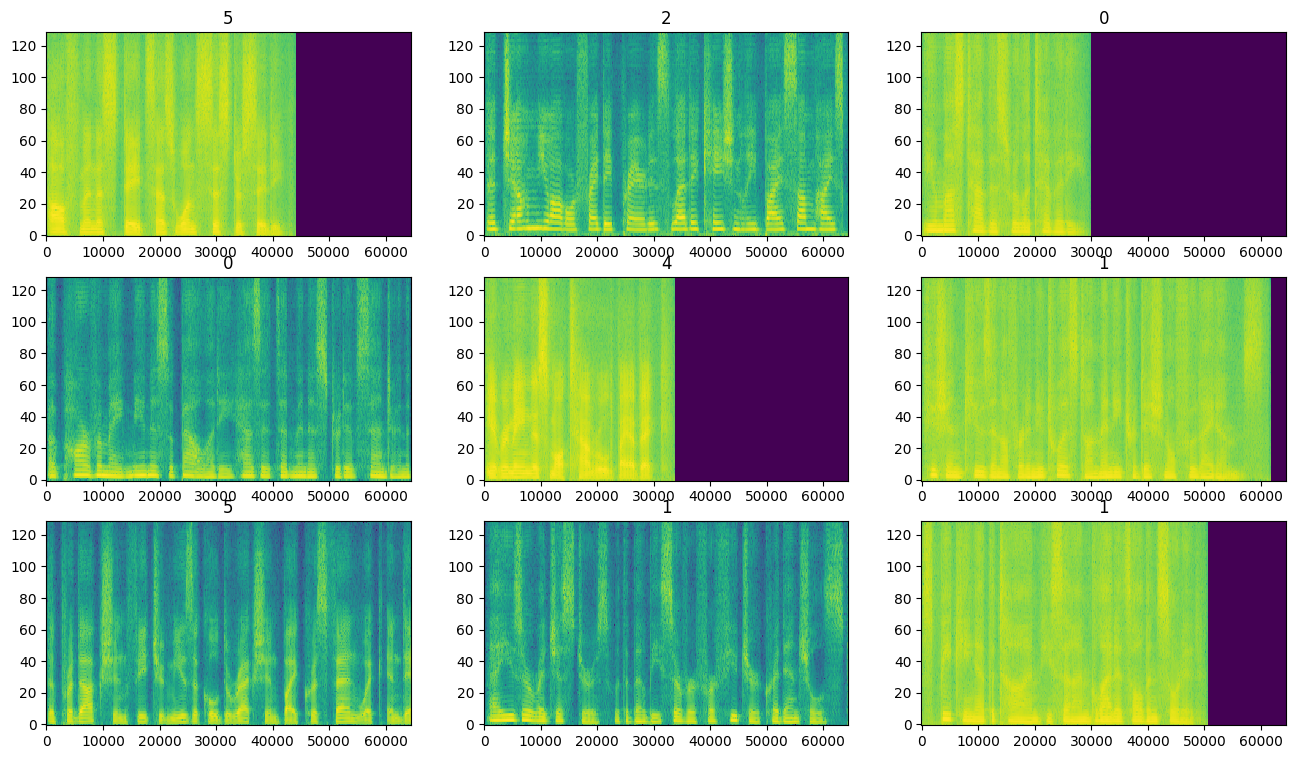

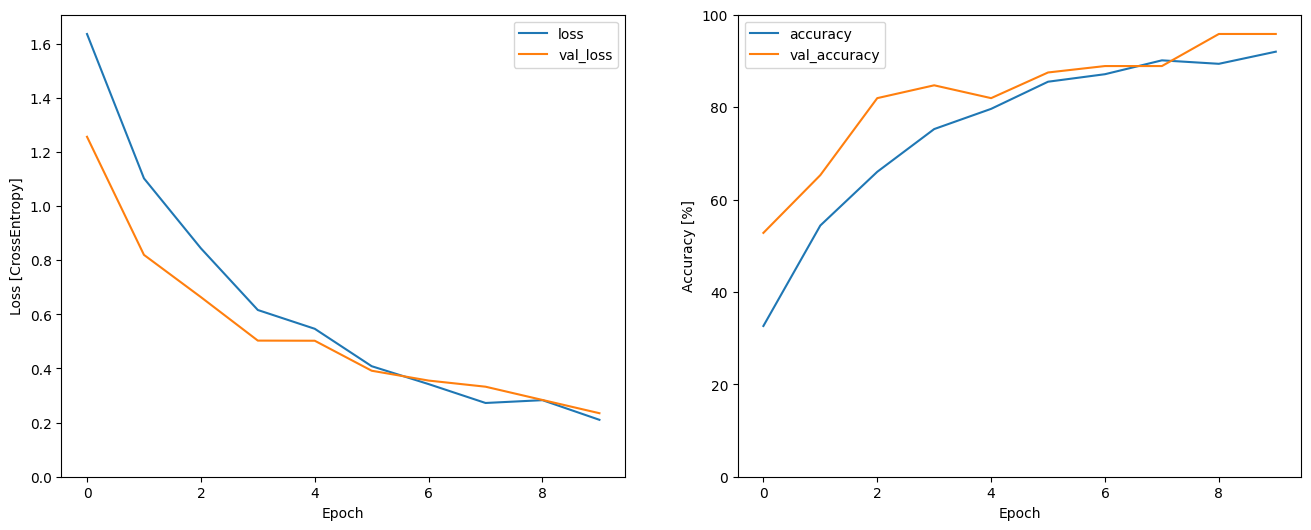

In [ ]:
%matplotlib inline
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True, verbose=True)
y_pred = model.predict(test_spectrogram_ds)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
y_labels = np.concatenate([y for x, y in test_spectrogram_ds], axis=0)

from sklearn.metrics import classification_report

y_pred = model.predict(test_spectrogram_ds)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_labels, y_pred_bool))

2/2 [==============================] - 0s 49ms/step
              precision    recall  f1-score   support

           0       0.86      0.70      0.78        27
           1       0.73      0.86      0.79        22
           2       0.94      1.00      0.97        16
           3       0.95      0.95      0.95        19
           4       0.96      0.92      0.94        24
           5       0.95      1.00      0.98        20

    accuracy                           0.89       128
   macro avg       0.90      0.91      0.90       128
weighted avg       0.89      0.89      0.89       128



##### Calculate word error rate
- Audio transcription
- Match with original text (each word)
- Calculate error

In [29]:
def wer(ref, hyp ,debug=True):
    r = ref.split()
    h = hyp.split()
    #costs will holds the costs, like in the Levenshtein distance algorithm
    costs = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
    # backtrace will hold the operations we've done.
    # so we could later backtrace, like the WER algorithm requires us to.
    backtrace = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
 
    OP_OK = 0
    OP_SUB = 1
    OP_INS = 2
    OP_DEL = 3
    DEL_PENALTY = 1
    INS_PENALTY = 1
    SUB_PENALTY = 1
    
    # First column represents the case where we achieve zero
    # hypothesis words by deleting all reference words.
    for i in range(1, len(r)+1):
        costs[i][0] = DEL_PENALTY*i
        backtrace[i][0] = OP_DEL
    
    # First row represents the case where we achieve the hypothesis
    # by inserting all hypothesis words into a zero-length reference.
    for j in range(1, len(h) + 1):
        costs[0][j] = INS_PENALTY * j
        backtrace[0][j] = OP_INS
    
    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                costs[i][j] = costs[i-1][j-1]
                backtrace[i][j] = OP_OK
            else:
                substitutionCost = costs[i-1][j-1] + SUB_PENALTY # penalty is always 1
                insertionCost    = costs[i][j-1] + INS_PENALTY   # penalty is always 1
                deletionCost     = costs[i-1][j] + DEL_PENALTY   # penalty is always 1
                 
                costs[i][j] = min(substitutionCost, insertionCost, deletionCost)
                if costs[i][j] == substitutionCost:
                    backtrace[i][j] = OP_SUB
                elif costs[i][j] == insertionCost:
                    backtrace[i][j] = OP_INS
                else:
                    backtrace[i][j] = OP_DEL
                 
    # back trace though the best route:
    i = len(r)
    j = len(h)
    numSub = 0
    numDel = 0
    numIns = 0
    numCor = 0
    if debug:
        print("OP\tREF\tHYP")
        lines = []
    while i > 0 or j > 0:
        if backtrace[i][j] == OP_OK:
            numCor += 1
            i-=1
            j-=1
            if debug:
                lines.append("OK\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_SUB:
            numSub +=1
            i-=1
            j-=1
            if debug:
                lines.append("SUB\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_INS:
            numIns += 1
            j-=1
            if debug:
                lines.append("INS\t" + "****" + "\t" + h[j])
        elif backtrace[i][j] == OP_DEL:
            numDel += 1
            i-=1
            if debug:
                lines.append("DEL\t" + r[i]+"\t"+"****")
    if debug:
        lines = reversed(lines)
        for line in lines:
            print(line)
        print("#cor " + str(numCor))
        print("#sub " + str(numSub))
        print("#del " + str(numDel))
        print("#ins " + str(numIns))
    # return (numSub + numDel + numIns) / (float) (len(r))
    wer_result = round( (numSub + numDel + numIns) / (float) (len(r)), 3)
    return {'WER':wer_result, 'numCor':numCor, 'numSub':numSub, 'numIns':numIns, 'numDel':numDel, "numCount": len(r)}

In [30]:
# Calculate word error rate for all sentences
i=0
r = sr.Recognizer()
for sentence in df.sentence:  
  # Transcribe fake audio                                       
  with sr.AudioFile(f"data/fake/{i}.wav") as source:
    audio = r.record(source)  # read the entire audio file
    try:
      df.loc[i,'fake_transcription'] = r.recognize_google(audio)
    except:
      df.loc[i,'fake_transcription'] = ''

  # Calculate word error rate  
  df.loc[i, 'wer'] = wer(sentence, df.loc[i, 'fake_transcription'], debug=False)['WER']

  i += 1

FileNotFoundError: ignored

In [ ]:
print(f"The average word error rate (WER) is {df.loc[:, 'wer'].mean()}")

#### Voice cloning with YourTTS
Using the YourTTS model provided by the TTS package, we’ll take each speech file provided in the TIMIT dataset and convert it to a synthetically generated audio with another (randomly selected) speaker from one of the 630 available.

We’ll then measure the Word Error Rate (WER) for each of the generated clips and also report speaker classification accuracy.

In [16]:
import random

In [17]:
# List available 🐸TTS models and choose the first one
model_name = TTS.list_models()[0]

# Init TTS
tts = TTS(model_name)

No API token found for 🐸Coqui Studio voices - https://coqui.ai 
Visit 🔗https://app.coqui.ai/account to get one.
Set it as an environment variable `export COQUI_STUDIO_TOKEN=<token>`

 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256

In [56]:
df = pd.DataFrame()
train_paths = list(paths.list_files("/content/timit/archive/data/TRAIN/", ".wav", ".WAV.wav"))
i=0
r = sr.Recognizer()
# For each file in TRAIN
for path in train_paths:
  df.loc[i,'path'] = path
  # Recognise sentence
  with sr.AudioFile(path) as source:
    audio = r.record(source)
    try:
      df.loc[i,'recognised_sentence'] = r.recognize_google(audio)
    except:
      df.loc[i,'recognised_sentence'] = ""

  #tts.tts_to_file(df.sample()['sentence'].values[0], speaker_wav=path, language="en", file_path=f"data/fake/{i}.wav")
  random_wav = random.choice(train_paths)
  df.loc[i,'speaker'] = random_wav.split("/")[7]
  df.loc[i,'dialect'] = random_wav.split("/")[6]
  
  tts.tts_to_file(df.loc[i,'recognised_sentence'], speaker_wav=random_wav, language="en", file_path=f"data/fake/{i}.wav")
  # Transcribe fake audio
  with sr.AudioFile(f"data/fake/{i}.wav") as source:
    audio = r.record(source)
    try:
      df.loc[i,'generated_sentence'] = r.recognize_google(audio)
    except:
      df.loc[i,'generated_sentence'] = ""

  # Get word error rate
  text_filename = f'{path.split("/")[8][:-8]}.TXT'
  original_dialect = path.split("/")[6]
  original_speaker = path.split("/")[7]
  f = open(f'/content/timit/archive/data/TRAIN/{original_dialect}/{original_speaker}/{text_filename}', 'r')

  text = f.read().split(' ', 2)[2].rstrip()

  df.loc[i,'original_sentence'] = text[:-1]
  df.loc[i,'wer'] = wer(df.loc[i,'original_sentence'], df.loc[i,'generated_sentence'], debug=False)['WER']
  i += 1

  if i > 100:
    break

 > Text splitted to sentences.
["don't ask me to carry an oily rag like that"]
 > Processing time: 3.171964168548584
 > Real-time factor: 0.9811209924369266
 > Text splitted to sentences.
['the misprint vote immediate disclaimer']
 > Processing time: 3.171468734741211
 > Real-time factor: 1.0007790264251217
 > Text splitted to sentences.
['the thick Elm forest was nearly overwhelmed by Dutch elm disease']
 > Processing time: 4.878474473953247
 > Real-time factor: 1.2492892378881555
 > Text splitted to sentences.
['and two cases airplanes only wear indicator']
 > Processing time: 4.928148508071899
 > Real-time factor: 1.412481658948667
 > Text splitted to sentences.
['her home became a gurgle of surprise']
 > Processing time: 3.5292396545410156
 > Real-time factor: 1.404393018122171
 > Text splitted to sentences.
['the speech Symposium might begin Monday']
 > Processing time: 4.847336530685425
 > Real-time factor: 1.711025955060157
 > Text splitted to sentences.
['Rich look for spotted 

In [57]:
df.head()

,path,recognised_sentence,speaker,dialect,generated_sentence,original_sentence,wer
0,/content/timit/archive/data/TRAIN/DR1/MDAC0/SA...,don't ask me to carry an oily rag like that,MRTJ0,DR3,don't ask me to carry and oily Ride Like That,Don't ask me to carry an oily rag like that,0.500
1,/content/timit/archive/data/TRAIN/DR1/MDAC0/SX...,the misprint vote immediate disclaimer,MPRK0,DR4,the misprint folding media disclaimer,The misprint provoked an immediate disclaimer,0.667
2,/content/timit/archive/data/TRAIN/DR1/MDAC0/SX...,the thick Elm forest was nearly overwhelmed by...,MDAC0,DR1,I think I'm forest was nearly overwhelmed by D...,The thick elm forest was nearly overwhelmed by...,0.455
3,/content/timit/archive/data/TRAIN/DR1/MDAC0/SI...,and two cases airplanes only wear indicator,MDSJ0,DR5,and two cases airplanes only wear indicator,"In two cases, airplanes only were indicated",0.571
4,/content/timit/archive/data/TRAIN/DR1/MDAC0/SI...,her home became a gurgle of surprise,MCTH0,DR7,home became a gurgle of surprise,Her hum became a gurgle of surprise,0.286


In [58]:
print(f'There are {len(list(paths.list_files("/content/data/fake", ".wav")))} generated fake samples.')

There are 101 generated fake samples.


### Build a fake audio detection system



We can load the data using `keras.utils.audio_dataset_from_directory`.

In [95]:
data_dir = '/content/data'
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=64000, # Set the length of the output to be 4 seconds
    subset='both')

label_names = np.array(train_ds.class_names)

print("\nlabel names:", label_names)

Found 1101 files belonging to 3 classes.
Using 881 files for training.
Using 220 files for validation.

label names: ['fake' 'fake_by_speaker' 'real']


In [96]:
train_ds.element_spec

(TensorSpec(shape=(None, 64000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [97]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [98]:
# Break up val_ds into a validation and test set
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [99]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 64000)
(64,)


In [100]:
# Convert waveforms to spectograms
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [101]:
label_names

array(['fake', 'fake_by_speaker', 'real'], dtype='<U15')

In [102]:
for i in range(6):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


In [103]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Now create spectrogram datasets from the audio datasets

In [104]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [105]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [106]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [107]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Now lets build and train the model

In [108]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [109]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (499, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)       

In [110]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [111]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
14/14 [==============================] - 5s 319ms/step - loss: 0.3424 - accuracy: 0.8978 - val_loss: 0.1863 - val_accuracy: 0.8913
Epoch 2/10
14/14 [==============================] - 4s 314ms/step - loss: 0.0911 - accuracy: 0.9625 - val_loss: 0.1371 - val_accuracy: 0.9783
Epoch 3/10
14/14 [==============================] - 6s 422ms/step - loss: 0.0565 - accuracy: 0.9739 - val_loss: 0.0930 - val_accuracy: 0.9891
Epoch 4/10
14/14 [==============================] - 3s 228ms/step - loss: 0.0321 - accuracy: 0.9864 - val_loss: 0.0695 - val_accuracy: 0.9891
Epoch 5/10
14/14 [==============================] - 3s 234ms/step - loss: 0.0244 - accuracy: 0.9909 - val_loss: 0.0624 - val_accuracy: 0.9891
Epoch 6/10
14/14 [==============================] - 6s 427ms/step - loss: 0.0206 - accuracy: 0.9921 - val_loss: 0.0498 - val_accuracy: 0.9891
Epoch 7/10
14/14 [==============================] - 4s 256ms/step - loss: 0.0213 - accuracy: 0.9955 - val_loss: 0.0500 - val_accuracy: 0.9891
Epoch 

In [112]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()

In [113]:
model.evaluate(test_spectrogram_ds, return_dict=True, verbose=True)

2/2 [==============================] - 1s 315ms/step - loss: 0.0709 - accuracy: 0.9844


{'loss': 0.07092569768428802, 'accuracy': 0.984375}

In [114]:
#y_pred = model.predict(test_spectrogram_ds)

In [115]:
#y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

### Run inference with my voice

In [ ]:
list(paths.list_files("/content/data/me", ".wav"))

In [ ]:
# TODO: Record an audio (not fake) and do an inference with the model
my_paths = list(paths.list_files("/content/data/me", ".wav"))

for path in my_paths:
  x = tf.io.read_file(str(path))
  x, sample_rate = tf.audio.decode_wav(x, desired_samples=64000,)
  x = tf.squeeze(x, axis=-1)
  waveform = x
  x = get_spectrogram(x)
  x = x[tf.newaxis,...]

  %matplotlib inline
  prediction = model(x)
  x_labels = ['fake', 'real']
  plt.bar(x_labels, tf.nn.softmax(prediction[0]))
  plt.title('Voice Clip Prediction')
  plt.show()

  display.display(display.Audio(waveform, rate=16000))

Now lets use the voice cloner to generate fake samples of my voice.

In [ ]:
real_voice_paths = list(paths.list_files("/content/data/me", ".wav"))

i=0
for path in real_voice_paths:
  tts.tts_to_file(df.sample()['sentence'].values[0], speaker_wav=path, language="en", file_path=f"data/me_fake/{i}.wav")
  i += 1

In [ ]:
my_paths = list(paths.list_files("/content/data/me_fake", ".wav"))

for path in my_paths:
  x = tf.io.read_file(str(path))
  x, sample_rate = tf.audio.decode_wav(x, desired_samples=64000,)
  x = tf.squeeze(x, axis=-1)
  waveform = x
  x = get_spectrogram(x)
  x = x[tf.newaxis,...]

  %matplotlib inline
  prediction = model(x)
  x_labels = ['fake', 'real']
  plt.bar(x_labels, tf.nn.softmax(prediction[0]))
  plt.title('Voice Clip Prediction')
  plt.show()

  display.display(display.Audio(waveform, rate=16000))

### Results

#### WER
Lets calculate the average WER.

In [59]:
print(f'The average WER is {df.loc[:, "wer"].mean()}')

The average WER is 0.43170297029702975


Lets do a boxplot of the WER.

In [60]:
import plotly.express as px
fig = px.box(df, y="wer")
fig.show()

Lets calculate the average WER by dialect.

In [54]:
df.groupby('dialect')['wer'].mean()

dialect
DR1    0.318200
DR2    0.347000
DR3    0.469154
DR4    0.417500
DR5    0.441111
DR6    0.524800
DR7    0.446478
DR8    0.477556
Name: wer, dtype: float64

These results show that the majority of samples were produced with a WER of between 28% and 58%. The most accurate samples were produced with dialect DR1, which is the New England region of USA. The least accurate was DR6 (New York City).

#### F-Score

In [116]:
y_labels = np.concatenate([y for x, y in test_spectrogram_ds], axis=0)

In [117]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_spectrogram_ds)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_labels, y_pred_bool))


2/2 [==============================] - 0s 56ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           2       0.99      0.99      0.99       120

    accuracy                           0.98       128
   macro avg       0.93      0.93      0.93       128
weighted avg       0.98      0.98      0.98       128



### Summary
We were able to produce a model that identifies ‘fake’ and ‘real’ speech audio to a high accuracy.

The voice cloner component used the TIMIT dataset and the YourTTS model to generate 'fake' synthetic voice samples. Overall, the WER was below 50%.

The fake speech detector model was built using these 'fake' samples and real samples from the CommonVoice Dataset. It performed at a high average F-score of > 95%.

There are however some improvements that can be made to the overall system - particularly in regards to reducing the WER.

#### Possible Improvements
- The quality of the voice cloner could be improved by building a custom model on our TIMIT dataset that accounts for all 8 of the different dialects provided
- We are using the [SpeechRecognition Python package](https://pypi.org/project/SpeechRecognition/) for determining the words spoken from the source voice clips and to measure the WER. There continues to be significant advancements in the field of voice transcriptions and the word accuracy of our voice cloning could be improved by using the latest speech-to-text models such as [Whisper API](https://whisperapi.com).
- We could improve our model further by accounting for background noise by adding some synthetic background noise to our ‘fake’ samples. Listening to some of the real voice clips, we can hear some evident background noise in most of the samples. The synthetically generated clips do not contain any background noise at all.